Takes the whole relabeled old dataset, computes each signals FFT and PSD, and then computes and plots the average FFT and PSD.

In [19]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch
from src.utils.path_utils import get_processed_old_data_dir, get_processed_fast_data_dir, get_processed_data_dir

In [20]:
# ----------- FFT & PSD Aggregators ------------


In [35]:
# ----------- Folder Setup ------------
old_relabeled_files = sorted(glob.glob(os.path.join(str(get_processed_old_data_dir()), "**/*.csv"), recursive=True))
fast_relabeled_files = sorted(glob.glob(os.path.join(str(get_processed_fast_data_dir()), "**/*.csv"), recursive=True))
all_relabeled_files = sorted(glob.glob(os.path.join(str(get_processed_data_dir()), "**/*.csv"), recursive=True))

if not csv_files:
    raise FileNotFoundError("No signal files found.")

In [46]:
# ----------- Process Each File ------------
def calc_fft_psd(csv_files, header=None):
    label_names = {
        0: "Rest",
        1: "Grip",
        2: "Hold",
        3: "Release"
    }
    fft_results = {label: [] for label in range(4)}
    psd_results = {label: [] for label in range(4)}
    fft_freqs = None
    psd_freqs = None

    for file_path in csv_files:
        data = pd.read_csv(file_path, header=header, names=['time', 'voltage', 'label'])

        time_diffs = np.diff(data['time'])
        sampling_rate = 1 / np.median(time_diffs)

        for label in sorted(data['label'].unique()):
            segment = data[data['label'] == label]
            voltage = segment['voltage'].values

            if len(voltage) < 512:
                continue

            # FFT
            n = len(voltage)
            freqs = np.fft.rfftfreq(n, d=1 / sampling_rate)
            fft_vals = np.fft.rfft(voltage)
            fft_magnitude = np.abs(fft_vals)

            if fft_freqs is None:
                fft_freqs = freqs
            else:
                fft_magnitude = np.interp(fft_freqs, freqs, fft_magnitude)

            fft_results[label].append(fft_magnitude)

            # PSD
            psd_freq, psd = welch(voltage, fs=sampling_rate, nperseg=1024)

            if psd_freqs is None:
                psd_freqs = psd_freq
            else:
                psd = np.interp(psd_freqs, psd_freq, psd)

            psd_results[label].append(psd)

    return fft_results, psd_results, fft_freqs, psd_freqs

In [47]:
fft_results, psd_results, fft_freqs, psd_freqs = calc_fft_psd(old_relabeled_files)

In [59]:
# ----------- Plot Averaged FFT ------------
def plot_fft(fft_results, fft_freqs):
    fig_fft, axs_fft = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=True)
    axs_fft = axs_fft.flatten()

    for label in range(4):
        if fft_results[label]:
            avg_fft = np.mean(fft_results[label], axis=0)
            axs_fft[label].plot(fft_freqs, avg_fft, color='black')
            axs_fft[label].set_title(f"Average FFT - {label_names.get(label, f'Label {label}')}")
            axs_fft[label].set_xlim(5, 100)
            axs_fft[label].set_ylim(0, 350)
            axs_fft[label].set_ylabel("Magnitude")
            axs_fft[label].grid(True)

    for ax in axs_fft:
        ax.set_xlabel("Frequency (Hz)")

    fig_fft.suptitle("Average FFT Magnitude per Label", fontsize=16)
    plt.tight_layout()
    plt.show()

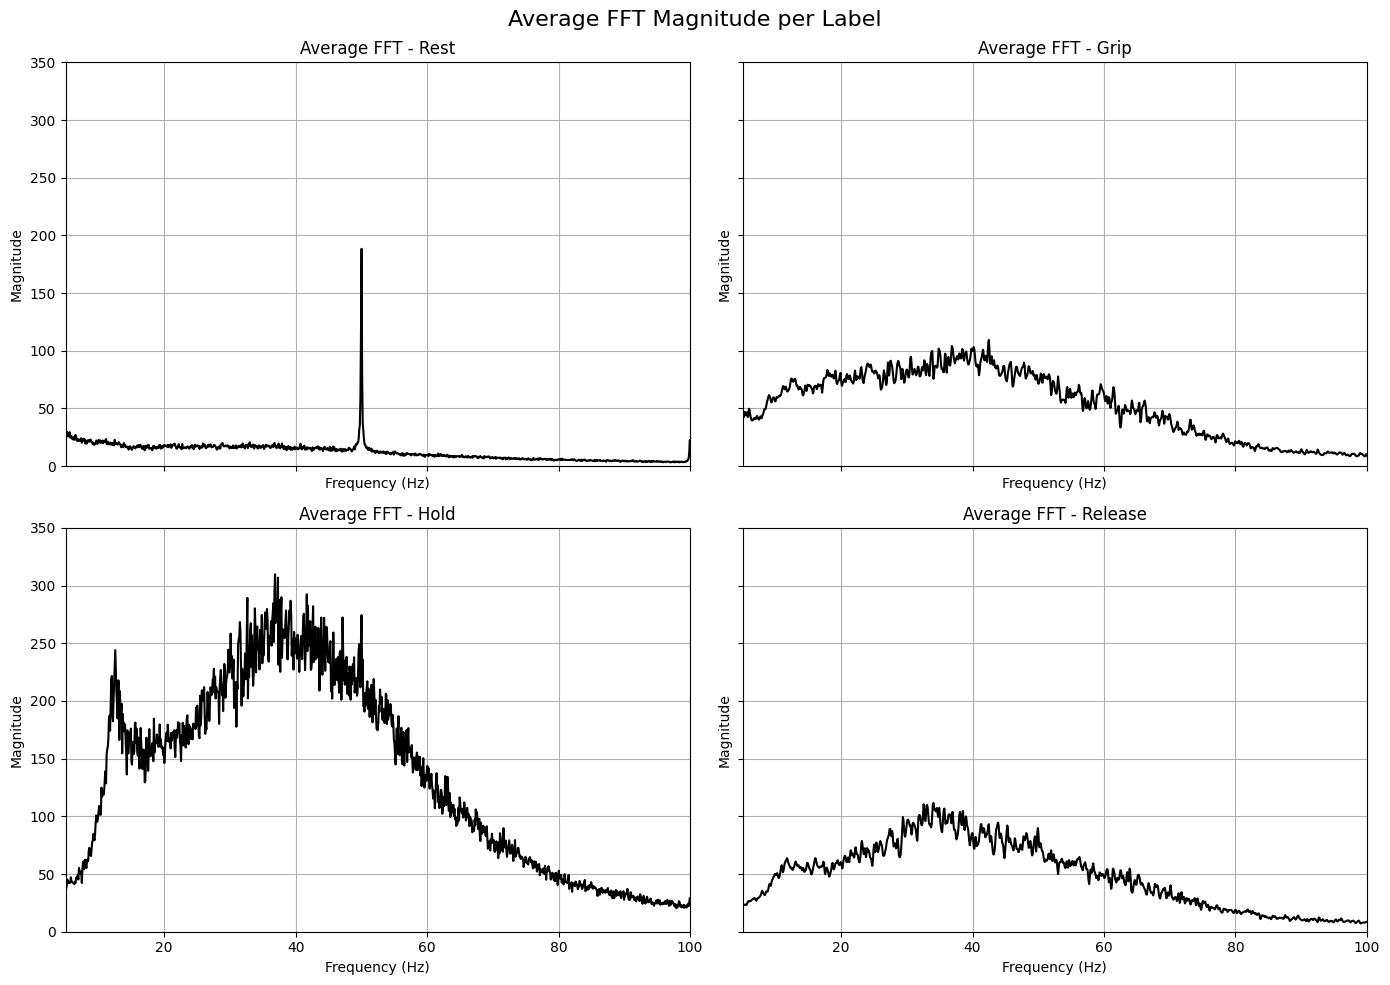

In [60]:
plot_fft(fft_results, fft_freqs)

In [50]:
# ----------- Plot Averaged PSD ------------
def plot_psd(psd_results, psd_freqs):
    fig_psd, axs_psd = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=True)
    axs_psd = axs_psd.flatten()

    for label in range(4):
        if psd_results[label]:
            avg_psd = np.mean(psd_results[label], axis=0)
            axs_psd[label].semilogy(psd_freqs, avg_psd, color='black')
            axs_psd[label].set_title(f"Average PSD - {label_names.get(label, f'Label {label}')}")
            axs_psd[label].set_xlim(20, 200)
            axs_psd[label].set_ylabel("Power/Freq (V²/Hz)")
            axs_psd[label].grid(True)

    for ax in axs_psd:
        ax.set_xlabel("Frequency (Hz)")

    fig_psd.suptitle("Average PSD (Welch) per Label", fontsize=16)
    plt.tight_layout()
    plt.show()

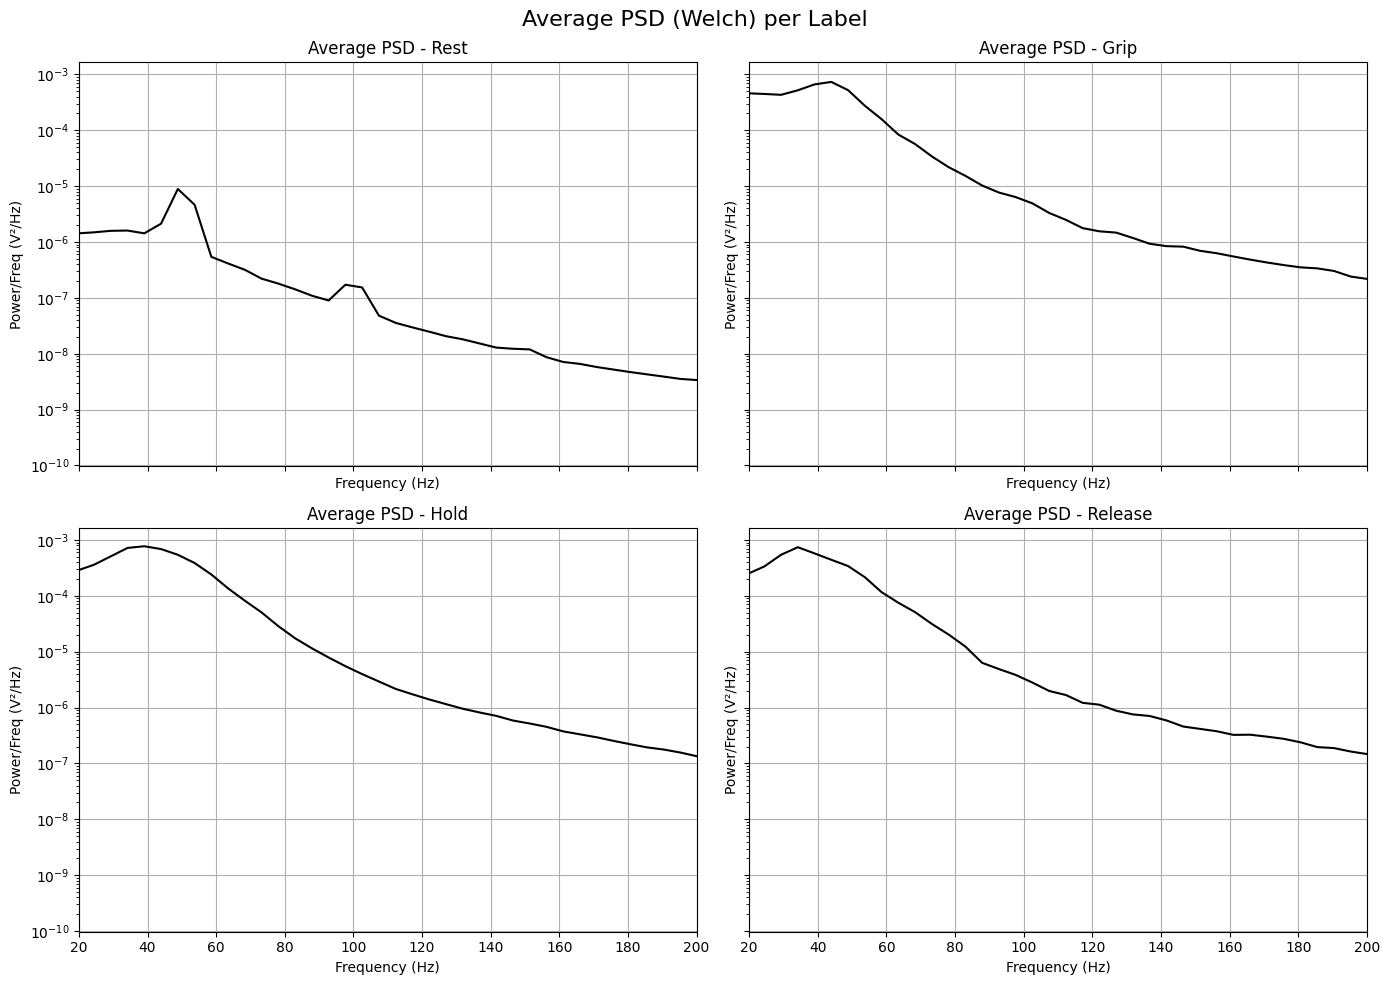

In [51]:
plot_psd(psd_results, psd_freqs)

In [53]:
fft_results, psd_results, fft_freqs, psd_freqs = calc_fft_psd(fast_relabeled_files, header=0)

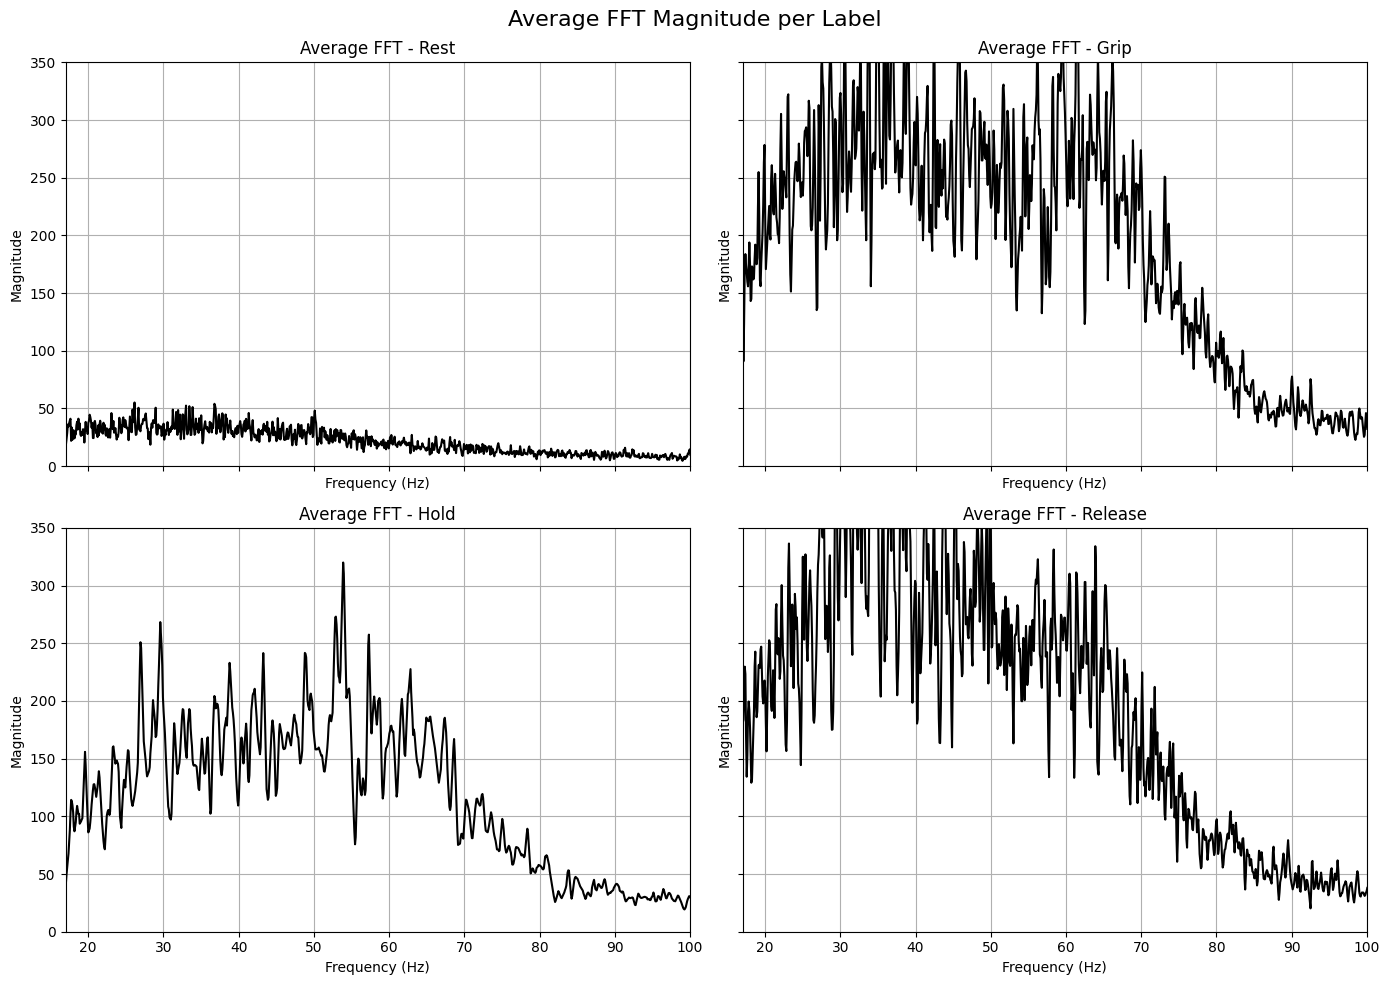

In [54]:
plot_fft(fft_results, fft_freqs)

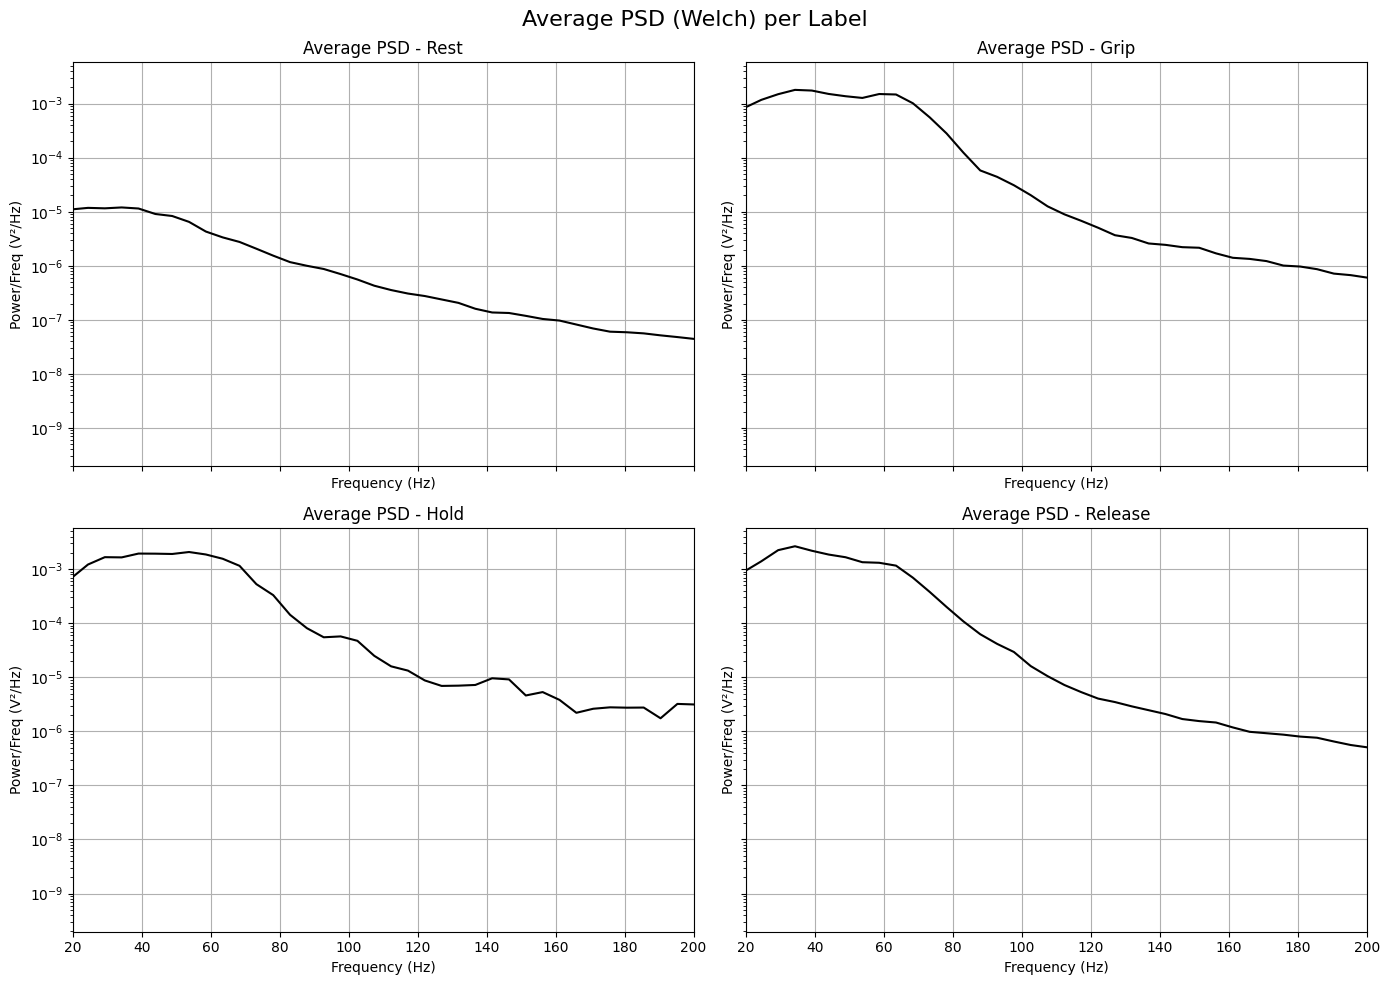

In [55]:
plot_psd(psd_results, psd_freqs)

In [56]:
fft_results, psd_results, fft_freqs, psd_freqs = calc_fft_psd(all_relabeled_files, header=0)

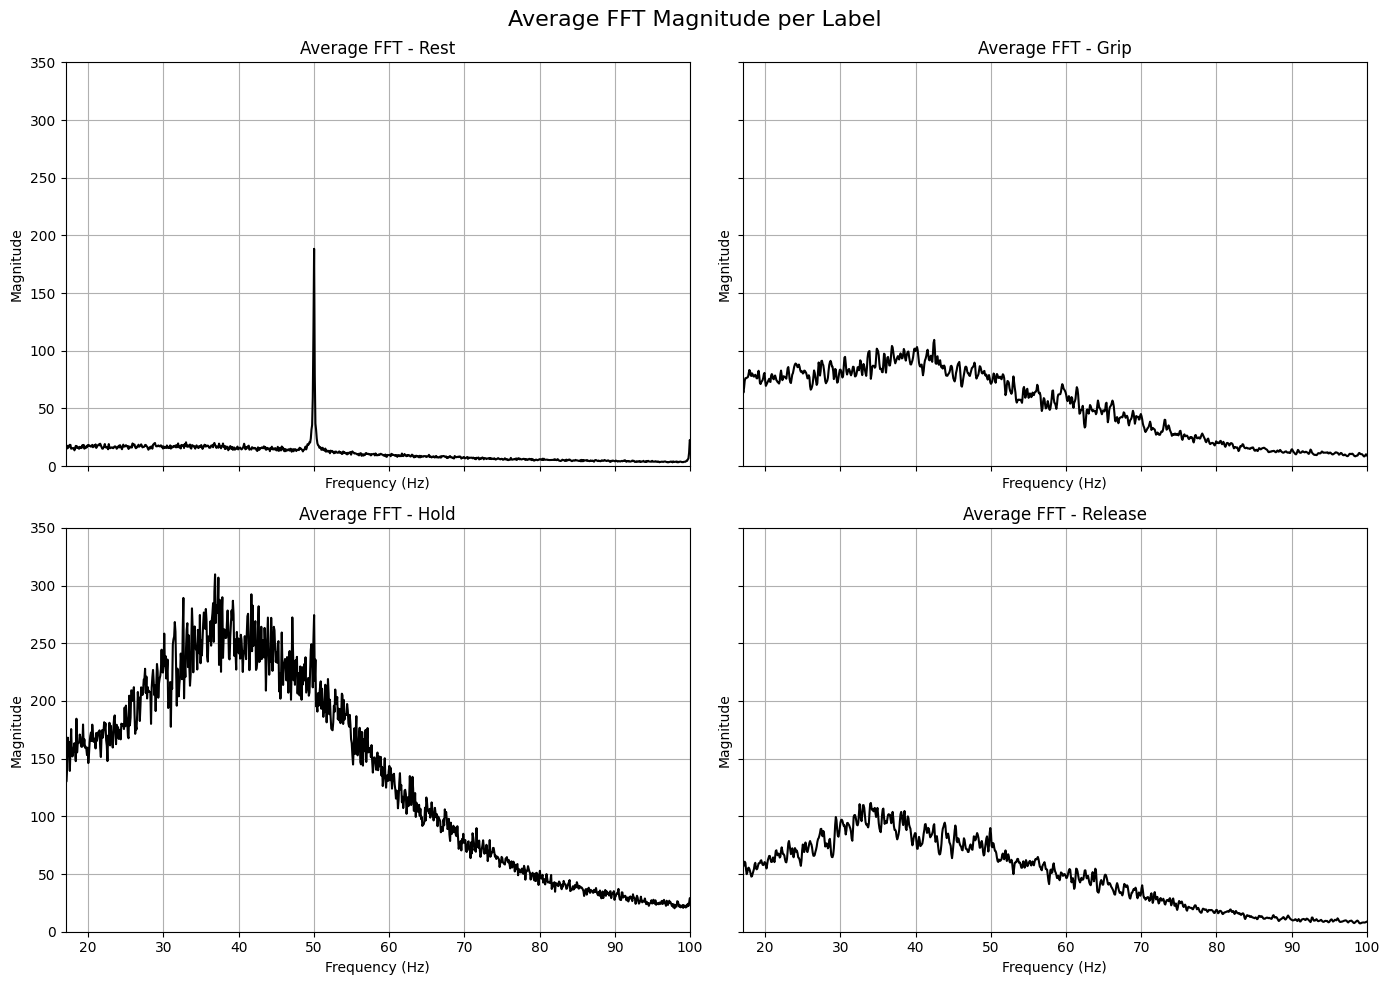

In [57]:
plot_fft(fft_results, fft_freqs)

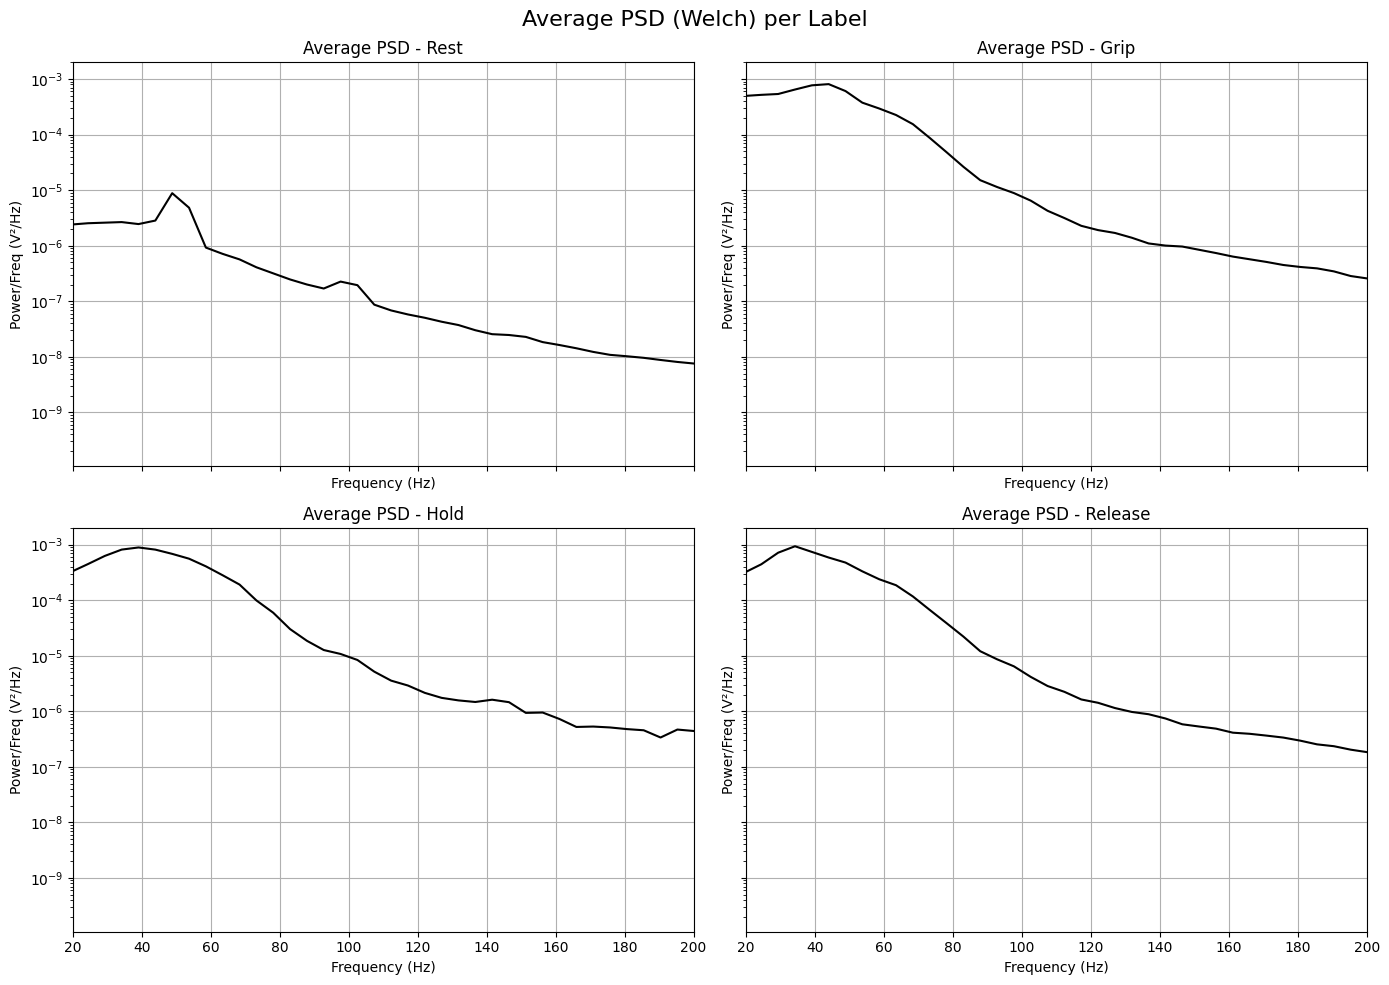

In [58]:
plot_psd(psd_results, psd_freqs)